In [2]:
import xarray as xr
import rioxarray
import pyproj
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from matplotlib import pyplot as plt

# CODE

In [3]:
# for testing
def get_chunks_indices(xr_array: xr.Dataset) -> list:
    """Get the indices for chunked slices of an xarray Dataset.

    Determines the chunk boundaries of the given xarray and returns a list
    of slice objects representing these chunks.

    Parameters
    ----------
    xr_array : xr.Dataset
        The input xarray Dataset.

    Returns
    -------
    list
        A list of slice objects representing the chunked slices.

    """
    chunks = xr_array.chunksizes
    iy, ix = chunks["y"], chunks["x"]

    idx = [sum(ix[:i]) for i in range(len(ix) + 1)]
    idy = [sum(iy[:i]) for i in range(len(iy) + 1)]

    slices = []

    for i in range(len(idy) - 1):  # Y-axis slices for idy
        for j in range(len(idx) - 1):  # X-axis slices for idx
            # Create a slice using the ranges of idt, idy, and idx
            # skip first date
            slice_ = np.s_[:, idy[i] : idy[i + 1], idx[j] : idx[j + 1]]
            slices.append(slice_)
    return slices

In [41]:


def interpolate_3d(data_xs, data_ys, data_zs, data_ws, interpolation_points, fill_value=None, assume_sorted=False):
    """
    Perform trilinear interpolation for a given set of points.

    Parameters:
        data_xs (array): 1D array of x-coordinates.
        data_ys (array): 1D array of y-coordinates.
        data_zs (array): 1D array of z-coordinates.
        data_ws (3D array): 3D array of function values.
        interpolation_points (array): Nx3 array of interpolation points.
        fill_value (float, optional): Value to use for out-of-bounds points.
        assume_sorted (bool): If True, assumes input arrays are sorted.

    Returns:
        np.array: Interpolated values at the given points.
    """
    if not assume_sorted:
        sorted_x = np.argsort(data_xs)
        sorted_y = np.argsort(data_ys)
        sorted_z = np.argsort(data_zs)
        data_xs = np.array(data_xs)[sorted_x]
        data_ys = np.array(data_ys)[sorted_y]
        data_zs = np.array(data_zs)[sorted_z]
        data_ws = np.array(data_ws)[np.ix_(sorted_x, sorted_y, sorted_z)]
    
    interpolator = RegularGridInterpolator((data_xs, data_ys, data_zs), data_ws, method='cubic',
                                           bounds_error=False, fill_value=fill_value)
    return interpolator(interpolation_points)

# Option1 
def interp_with_dem(dem_xr, tropo_xr):
    # DEM extent
    min_x, min_y, max_x, max_y = dem_xr.rio.bounds()

    # Take 5 values above max DEM height, and add 1km above it
    isel = dict(longitude=slice(min_x-0.2, max_x+0.2),
                latitude=slice(max_y+0.2, min_y-0.2))

    
    # Interpolate to same lat, lon grid
    tropo_ds = tropo_xr.sel(isel)

    # Get 3d interpolation grid
    X_grid, Y_grid = np.meshgrid(dem_xr.x, dem_xr.y, indexing="xy")

    ztd_interp =  interpolate_3d(tropo_ds.latitude, tropo_ds.longitude, tropo_ds.height, 
                                 tropo_ds.transpose('latitude','longitude', 'height').values,
                                 (Y_grid, X_grid, dem_xr))
    return xr.DataArray(ztd_interp, dims=('y','x'), 
                        coords={'y':dem_xr.y, 'x':dem_xr.x}).rio.write_crs('EPSG:4326', inplace=True)


# Option 2 linear horizontal and cubic in vertical
def interp_with_dem2(dem_xr, tropo_xr):
    # DEM extent
    min_x, min_y, max_x, max_y = dem_xr.rio.bounds()
    min_height, max_height = dem_xr.min().values, dem_xr.max().values

    isel = dict(longitude=slice(min_x-0.2, max_x+0.2),
                latitude=slice(max_y+0.2, min_y-0.2),
                height=slice(min_height-1e3, max_height+1e3))
    
    tropo_ds = tropo_xr.sel(isel).interp(longitude=dem_xr.x, 
                                         latitude=dem_xr.y, method="linear")

    # Get 3d interpolation grid
    X_grid, Y_grid = np.meshgrid(dem_xr.x, dem_xr.y, indexing="xy")
    #print('Interpolation to the surface elevation')
    ztd_interp =  interpolate_3d(tropo_ds.y, tropo_ds.x, tropo_ds.height, 
                                 tropo_ds.transpose('y','x', 'height').values,
                                 (Y_grid, X_grid, dem_xr))
    return xr.DataArray(ztd_interp, dims=('y','x'), 
                        coords={'y':dem_xr.y, 'x':dem_xr.x}).rio.write_crs('EPSG:4326', inplace=True)

# Workspace

## Get OPERA_DISP

In [5]:
# Load OPERA DISP reference and secondary date
ds_ref = xr.open_dataset('/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/products/OPERA_L3_DISP-S1_IW_F08622_VV_20231219T225125Z_20240205T225124Z_v1.1_20250219T180928Z/OPERA_L3_DISP-S1_IW_F08622_VV_20231219T225125Z_20240205T225124Z_v1.1_20250219T180928Z.nc')
ds_sec = xr.open_dataset('/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/products/OPERA_L3_DISP-S1_IW_F08622_VV_20231219T225125Z_20240217T225123Z_v1.1_20250219T180928Z/OPERA_L3_DISP-S1_IW_F08622_VV_20231219T225125Z_20240217T225123Z_v1.1_20250219T180928Z.nc')

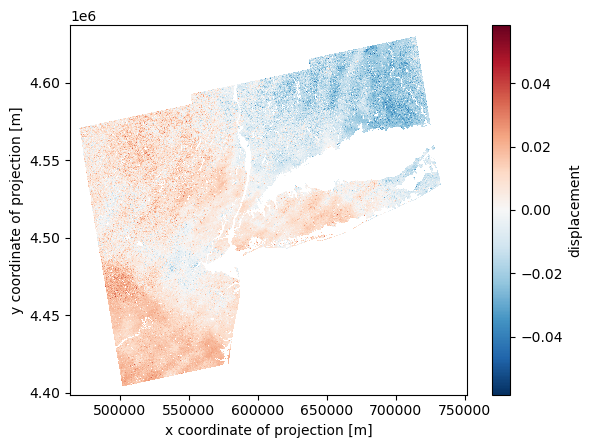

In [6]:
(ds_sec.displacement - ds_ref.displacement).where(ds_ref.water_mask==1).plot.imshow()

## Get DEM

In [7]:
epsg = pyproj.CRS.from_wkt(ds_ref.spatial_ref.attrs['crs_wkt']).to_epsg()
transform = pyproj.Transformer.from_crs(f"EPSG:{epsg}",  "EPSG:4326", always_xy=True)

# Get DISP extent in latitude/longitude with a buffer of 10km
buffer = 10e3
min_lon, min_lat = transform.transform(ds_ref.x.min().values - buffer,
                                       ds_ref.y.min().values - buffer)
max_lon, max_lat = transform.transform(ds_ref.x.max().values + buffer,
                                       ds_ref.y.max().values + buffer)

In [8]:
from dem_stitcher import stitch_dem

# load DEM and incidence angle
dem, p = stitch_dem([min_lon, min_lat, max_lon, max_lat],
                  dem_name='glo_30',  # Global Copernicus 30 meter resolution DEM
                  dst_ellipsoidal_height=True, # OPERA tropo is in elliposidal heights
                  dst_area_or_point='Point')

Opening glo_30 Datasets: 100%|██████████| 11/11 [00:22<00:00,  2.01s/it]
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dem_stitcher/rio_window.py:144: RuntimeWarning: Requesting extent beyond raster bounds of [-76.00013888888888, 39.00013888888889, -75.00013888888888, 40.00013888888889]. Shrinking bounds in raster crs to (-75.53549383023226, 39.64582091077148, -75.00013888888888, 40.00013888888889).
  warn(
Reading tile imagery: 100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


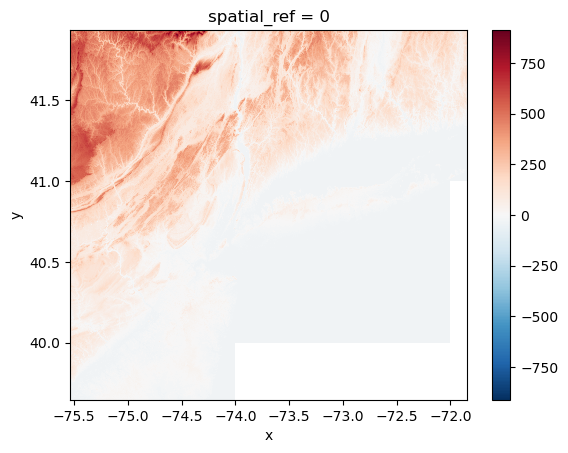

In [9]:
# Define metadata
width, height = p['width'], p['height']
transform = p['transform']
nodata_value = np.nan

# Generate coordinates
x = np.linspace(transform.c, transform.c + transform.a * (width - 1), width)
y = np.linspace(transform.f, transform.f + transform.e * (height - 1), height)

dem_ds = xr.DataArray(dem, dims=("y", "x"),
                     coords={"x": x, "y": y},
                     attrs={"crs": "EPSG:4326", "nodata": nodata_value}
                     )
dem_ds = dem_ds.rio.write_crs('EPSG:4326', inplace=True)
del dem
dem_ds.plot.imshow()

## Get incidence angle

In [10]:
import rasterio
with rasterio.open('/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/geometry/incidence.tif') as src:
    # Read the data as an array
    inc_angle = src.read(1)

## Calculate tropospheric correction
Note: PyAPS calculate ZTD with negative sign vs RAiDER with positive

In [33]:
# Load tropo, chose tropo closes to an aquisition time
tropo_ref1 = xr.open_dataset('/u/duvel-d2/govorcin/TROPO/output/OPERA_L4_TROPO-ZENITH_20240206T000000Z_20250402T025154Z_HRES_v0.2.nc', chunks={})
tropo_sec1 = xr.open_dataset('/u/duvel-d2/govorcin/TROPO/output/OPERA_L4_TROPO-ZENITH_20240218T000000Z_20250402T135531Z_HRES_v0.2.nc', chunks={})

In [37]:
isel =dict(latitude=slice(max_lat+0.2, min_lat-0.2),
           longitude=slice(min_lon-0.2, max_lon+0.2))
tropo_ref1 = tropo_ref1.sel(isel)
tropo_sec1 = tropo_sec1.sel(isel)

In [38]:
%%time
# Skip running 3d interpolation twice
# Get differential total ZTD (hydrostatic + wet), can be run on individual product and re-reference later
ztd1 = tropo_ref1.hydrostatic_delay + tropo_ref1.wet_delay
ztd2 = tropo_sec1.hydrostatic_delay + tropo_sec1.wet_delay

ztd = ztd2.isel(time=0) - ztd1.isel(time=0)

CPU times: user 11.8 ms, sys: 119 μs, total: 11.9 ms
Wall time: 11.2 ms


In [28]:
# Chunk DEM xr for calc
dem_ds = dem_ds.chunk({'x':128, 'y':128})

### Test it over one chunk

In [14]:
s = get_chunks_indices(dem_ds)
dem_ds_subset = dem_ds[s[0][1:]]

In [15]:
%%time
ip1 = interp_with_dem(dem_ds_subset, ztd)

CPU times: user 142 ms, sys: 9.67 ms, total: 151 ms
Wall time: 150 ms


In [16]:
%%time
ip2 = interp_with_dem2(dem_ds_subset, ztd)

CPU times: user 50.8 s, sys: 188 ms, total: 51 s
Wall time: 1.74 s


Text(0.5, 1.0, ' difference')

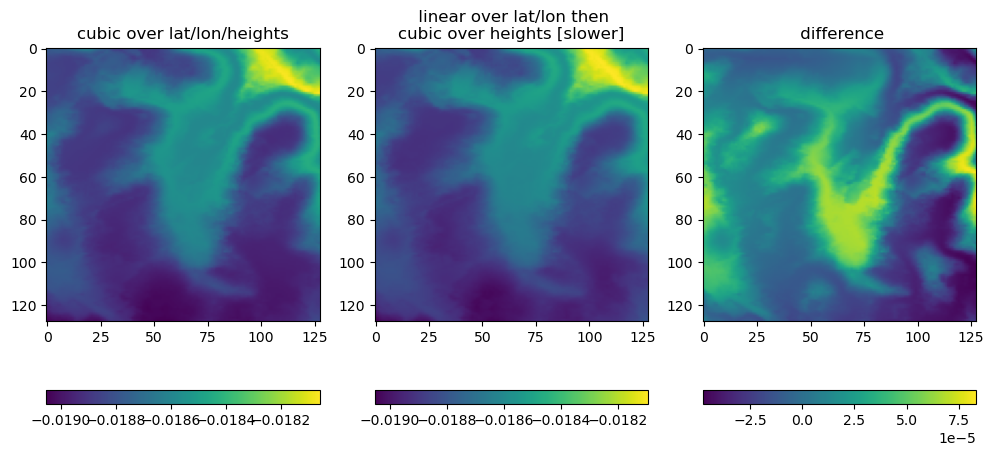

In [19]:
# Note difference neglible, first option is much faster
fig, ax = plt.subplots(1,3, figsize=(12,6))
im1 = ax[0].imshow(ip1)
fig.colorbar(im1, ax=ax[0],location='bottom')
ax[0].set_title('cubic over lat/lon/heights')
im2 = ax[1].imshow(ip2)
fig.colorbar(im2, ax=ax[1],location='bottom')
ax[1].set_title(' linear over lat/lon then\ncubic over heights [slower]')

im3 = ax[2].imshow(ip1 - ip2)
fig.colorbar(im3, ax=ax[2],location='bottom')
ax[2].set_title(' difference')

## DISP correction

In [42]:
%%time
template = xr.zeros_like(dem_ds)
tropo_corr = dem_ds.map_blocks(interp_with_dem, kwargs={'tropo_xr':ztd.load()},
                         template=template).compute()

CPU times: user 12min 19s, sys: 2min 23s, total: 14min 43s
Wall time: 6min 53s


In [21]:
## Reference differential displacement
ts_diff = (ds_sec.displacement - ds_ref.displacement)
ts_diff -= ts_diff[3500, 3500]

In [60]:
# Interpolate to same grid
tropo_corr = tropo_corr.rio.reproject(f'EPSG:{epsg}')
tropo_diff = tropo_corr.interp(x=ds_ref.x, y=ds_ref.y)


## Reference differential tropospheric correction
tropo_diff -= tropo_diff[3500,3500]

# Project to slant-range
tropo_diff /= np.cos(np.deg2rad(inc_angle))

# Reverse the sign
tropo_diff *= -1

Text(0.5, 1.0, 'CORRECTED DISP')

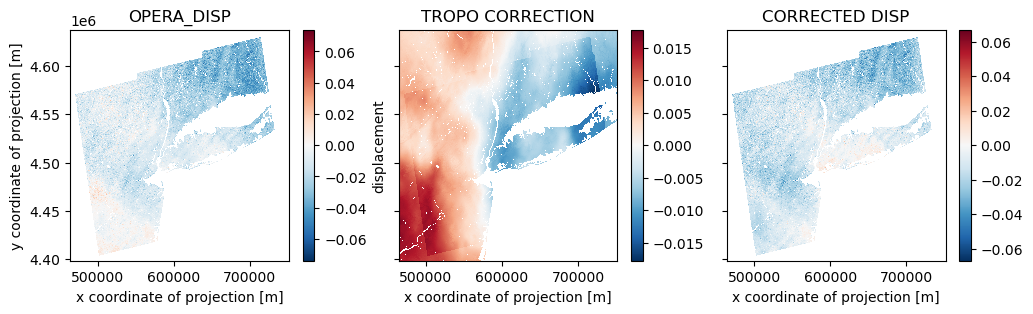

In [67]:
fig, ax = plt.subplots(1,3, figsize=(12,3), sharey=True)
ts_diff.where(ds_ref.water_mask==1).plot.imshow(ax=ax[0])
tropo_diff.where(ds_ref.water_mask==1).plot.imshow(ax=ax[1])
(ts_diff-tropo_diff).where(ds_ref.water_mask==1).plot.imshow(ax=ax[2])
for a in ax[1:]: a.set_ylabel('')
ax[0].set_title('OPERA_DISP')
ax[1].set_title('TROPO CORRECTION')
ax[2].set_title('CORRECTED DISP')